# Методы машинного обучения – Контрольная работа №4

# Нейронные сети MLP

Импортируем необходимые библиотеки:

In [1]:
# !pip install -q tfds-nightly
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

### Построение последовательных моделей нейронных сетей
* [Последовательные](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) модели — это самый простой вид нейронных сетей. Они состоят из ряда слоев, идущих один за другим.
* Существует [много типов слоев](https://www.tensorflow.org/api_docs/python/tf/keras/layers)
* Пока будем использовать только плотные [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) (полносвязные) слои. В плотных слоях имеется несколько важных настроек:
    * units: количество узлов (нейронов)
    * activation: [функция активации](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
    * kernel_initializer: как [инициализировать веса](https://www.tensorflow.org/api_docs/python/tf/keras/initializers)
    * kernel_regularizer: применять ли L1/L2 [регуляризацию](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers)
    
``` python
tf.keras.layers.Dense(
    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform',
    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None,
    activity_regularizer=None, kernel_constraint=None, bias_constraint=None,
    **kwargs
)
```

Рассмотрим следующую простую сеть с одним скрытым слоем:
* метод `Sequential.add()` добавляет слой в сеть
* также можно передать в конструктор массив слоев: `Sequential([layers])`
* используется активация `ReLU` для скрытого слоя и `SoftMax` для выходного слоя

In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(10, activation='softmax'))

C:\Users\Mo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### Входной слой
Обратите внимание, что входной слой может быть определен с помощью параметра `input_shape`. В качестве альтернативы также можно добавить явный входной слой.
В нашем случае данные представляют собой плоский массив из 28*28 входов.

In [3]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(28 * 28,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

C:\Users\Mo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


#### Слои активации
Большинство функций активации, инициализаторов и регуляризаторов можно указать в виде  ключевых слов. Если нужен больший контроль над нейронной сетью, то можно указать активацию как отдельный слой. Тогда плотный слой будет использовать линейную активацию, а в следующем слое будет применяться выбранная активация.

In [4]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(28 * 28,)))
model.add(layers.Dense(512))
model.add(layers.ReLU(negative_slope=0.1)) # слой leaky ReLU
model.add(layers.Dense(10, activation='softmax'))

#### Краткое описание модели
- вызов `model.summary()` выводит краткое описание модели по слоям
    - скрытый слой 1: (28 * 28 + 1) * 512 = 401920
    - скрытый слой 2: (512 + 1) * 512 = 262656
    - выходной слой: (512 + 1) * 10 = 5130

In [5]:
## добавим дополнительный скрытый слой для лучшей производительности
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [6]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

### Выбор функции потерь, оптимизатора, метрик

Вызов `model.compile()` указывает, как модель должна обучаться, т. е. какую функцию потерь и оптимизатор использовать и какие показатели оценки качества модели вычислять.

* __Функция потерь__ [см. обзор](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
     - Кросс-энтропия (логарифмические потери) для многоклассовой классификации (метка $y_{true}$ должна иметь прямое кодирование (one-hot encoded))
     - Используйте бинарную кросс-энтропию для задач бинарной классификации (один выходной нейрон)
     - Используйте разреженную категориальную кросс-энтропию, если выход $y_{true}$ закодирован метками 1,2,3,...
* __Оптимизатор__ [см. обзор](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
     - Любой из доступных оптимизаторов. `RMSprop` и `Adam` обычно работают хорошо.
* __Метрики__ [см. обзор](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)
     - Для мониторинга производительности во время обучения и тестирования, например,  доля верных ответов (accuracy)


Значения всех объектов можно указать с помощью текстовых слов:

In [7]:
# коротко
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

Для большего контроля можно передать названия фактических функций (с параметрами):

In [8]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

# детально
model.compile(loss = CategoricalCrossentropy(label_smoothing=0.01),
              optimizer = RMSprop(learning_rate=0.001, momentum=0.0),
              metrics = [Accuracy()])

### Обучение (подгонка)
Функция `fit` обучает сеть и возвращает историю потерь при обучении и проверке, а также значения всех метрик за эпоху.

```python
network.fit(X_train, y_train, epochs=3, batch_size=64)
```

Имеется два важных гиперпараметра:
* Количество эпох: должно быть достаточно, чтобы обеспечить сходимость
     * Слишком много: модель начинает переобучаться (или просто теряет время)
    
* Размер пакета: часто предпочтительнее небольшие пакеты (например, 32, 64 и т. д.)
     * «Зашумленные» обучающие данные  снижают вероятность переобучения
         * Большие пакеты хуже обобщаются
     * Требуют меньше памяти (особенно в графических процессорах)
     * Большие пакеты ускоряют обучение и сходимость достигается за меньшее количество эпох

#### Отслеживание прогресса обучения
Вызов `fit` обеспечивает вывод прогресса для каждой эпохи и возвращает объект `history`, содержащий все потери и показатели метрик оценки.

```python
history = network.fit(X_train, y_train, epochs=3, batch_size=64)
```

Можно также указать валидационную выборку, чтобы также возвращались показатели потерь и доли верных ответов на точность проверки. Параметр `verbose=0` заглушит выходные данные.

```python

history = network.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0,
                    validation_data=(X_val, y_val))
```

Возвращенная история обучения (объект `history`) содержит данные оценки качества модели (потери и метрики) для каждой эпохи.

### Прогнозы и оценки
Теперь можно вызывать `predict` для генерации прогнозов и оценить качество обученной модели на всем тестовом наборе при помощи `evaluate`.

``` python
network.predict(X_test)
test_loss, test_acc = network.evaluate(X_test, y_test)
```

### Бинарная классификация при помощи TensorFlow

__Бинарная (двоичная) классификация__ (binary classification) — это задача классификации элементов заданного набора данных в два класса.

Создадим синтетический набор данных при помощи функции `make_circles`:


In [9]:
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
y

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,

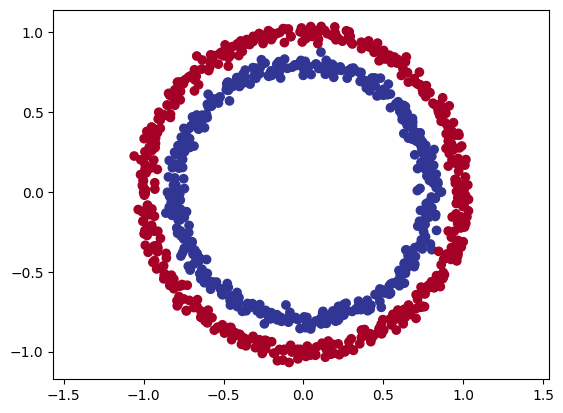

In [11]:
plt.scatter(X[:,0], X[:,1], c = y, cmap = plt.cm.RdYlBu)
plt.axis('equal');

Для визуализации областей принятия решения будем использовать следующую функцию (аналогичная функция определена в библиотеке `mlxtend`):

In [12]:
def plot_decision_boundary(model, X, y):
    # Найдем диапазоны изменения по осям и построим сетку
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    # Набор данных для прогнозирования
    X_in = np.c_[xx.ravel(), yy.ravel()]
    # Прогноз при помощи обученной модели
    y_pred = model.predict(X_in)
    # Проверка мультиклассовости
    if len(y_pred[1]) > 1:
        # мультиклассовая классификация
        # изменяем форму прогноза для визуализации
        y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
    else:
        # бинарная классификация
        y_pred = np.round(y_pred).reshape(xx.shape)
    # Рисуем границу решения
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

Рассмотрим нейронную сеть с одним слоем из одного нейрона и попробуем обучить ее бинарной классификации (для этого функция активации в выходном слое будет сигмоидой):

In [13]:
model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation = 'sigmoid')])
model_1.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
                metrics = ['accuracy'])
model_1.fit(X, y, epochs = 5);

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - accuracy: 0.5213 - loss: 0.7192 
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step - accuracy: 0.5127 - loss: 0.7090
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.4893 - loss: 0.7035
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - accuracy: 0.4744 - loss: 0.6988
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.4876 - loss: 0.6948


Нейронная сеть не обучается, а области принятия решения выглядят так:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


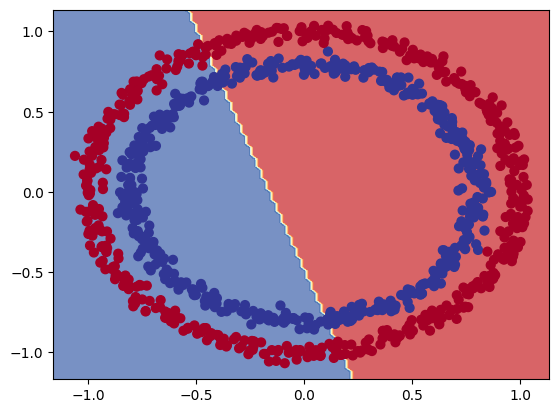

In [14]:
plot_decision_boundary(model_1, X, y)

Попробуем теперь использовать глубокую (многослойную) нейронную сеть с нелинейными функциями активации в скрытых слоях. Разобьем набор данных на обучающую и тестовую выборки:

In [15]:
X_train, y_train = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]
X_train.shape, X_test.shape

((800, 2), (200, 2))

In [16]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model_2.compile(loss= tf.keras.losses.binary_crossentropy,
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
                metrics = ['accuracy'])

In [17]:
model_2.fit(X_train, y_train, epochs = 125, verbose = 0);

In [18]:
loss, accuracy = model_2.evaluate(X_test, y_test)
print(f'Потери модели на тестовой выборке: {loss}')
print(f'Доля верных ответов на тестовой выборке: {100*accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.9914 - loss: 0.0291
Потери модели на тестовой выборке: 0.029835691675543785
Доля верных ответов на тестовой выборке: 99.00000095367432


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step


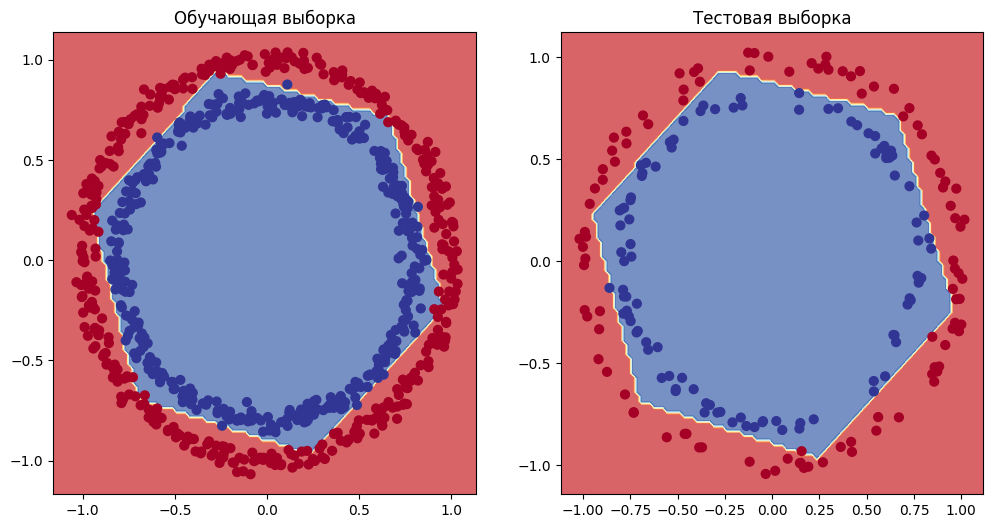

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Обучающая выборка")
plot_decision_boundary(model_2, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Тестовая выборка")
plot_decision_boundary(model_2, X=X_test, y=y_test)

### Важность признаков

Линейные алгоритмы машинного обучения строят модели, в которых прогноз представляет собой взвешенную сумму входных значений.

Примеры таких алгоритмов включают линейную регрессию, логистическую регрессию и их расширения, добавляющие регуляризацию, такие как гребневая регрессия и эластичная сеть.

Все эти алгоритмы находят набор коэффициентов для использования во взвешенной сумме, чтобы сделать прогноз. Эти же коэффициенты можно использовать в качестве предварительной оценки важности признаков.

Загрузим набор данных Ирисы:

In [20]:
ds = tfds.load("iris", split='train')
df = tfds.as_dataframe(ds)
for i in range(4):
    df['V'+str(i)] = df['features'].apply([lambda x:x[i]])
df.drop(columns=['features'],inplace=True)
df.sample(5)

,label,V0,V1,V2,V3
120,0,4.4,3.2,1.3,0.2
75,0,4.6,3.6,1.0,0.2
146,1,4.9,2.4,3.3,1.0
90,2,7.2,3.0,5.8,1.6
137,2,6.2,2.8,4.8,1.8


В наборе данных 150 записей, 4 независимых признака и метки классов:

In [21]:
df.shape

(150, 5)

В наборе данных отсутствуют пропущенные значения:

In [22]:
df.isnull().sum()

label    0
V0       0
V1       0
V2       0
V3       0
dtype: int64

Все столбцы числовые:

In [23]:
df.dtypes

label      int64
V0       float32
V1       float32
V2       float32
V3       float32
dtype: object

Сформируем массивы из признаков и меток класса:

In [24]:
X = np.array(df.drop('label', axis=1))
y = np.array(df['label'])

Оставим точки первых двух классов:

In [25]:
X = X[ y<2 ]
y = y[ y<2 ]

Создадим и адаптируем слой нормализации для всех признаков:

In [26]:
X.shape[1]

4

In [27]:
feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(X.shape[1],))
feature_normalizer.adapt(X)

C:\Users\Mo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Построим нейронную сеть с одним выходным нейроном с функцией активации сигмоида для решения задачи логистической регрессии:

In [28]:
model_aux = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_aux.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (None, 4)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8 (36.00 B)

 Trainable params: 5 (20.00 B)

 Non-trainable params: 3 (16.00 B)

Скомпилируем и обучим модель:

In [29]:
model_aux.compile(loss=tf.keras.losses.binary_crossentropy)
model_aux.fit(X, y, epochs=1000, verbose=0);

Посмотрим на значения весов в выходном слое:

In [30]:
model_aux.layers[1].kernel

<KerasVariable shape=(4, 1), dtype=float32, path=sequential_6/dense_13/kernel>

Веса в слое после обучения нейронной сети имеют значения, зависящие от случайных начальных значений, поэтому, вообще говоря, нужно строить несколько моделей и усреднять результаты.

Более высокие значения весов (по абсолютному значению) чаще всего означают более высокую важность признаков.

Таким образом, для определения важности признаков набора данных для бинарной классификации можно решать вспомогательную задачу построения и обучения нейронной сети для логистической регрессии.

### Задача класссификации

Пусть имеется множество объектов, характеризующихся признаками и разделённых некоторым образом на классы.

__Задача классификации__ — это задача построения алгоритма (функции), способного классифицировать произвольный объект из исходного пространства признаков, т.е. определять метку класса для этого объекта.

__Бинарная (двоичная) классификация__ (binary classification) — это задача классификации элементов заданного набора данных в два класса.

Для бинарной классификации могут применяться методы многоклассовой классификации, а также ряд специализированных методов, например, логистическая регрессия.

Задача классификации ирисов не является задачей бинарной классификации. Чтобы получить бинарную классификацию, оставим в наборе данных два первых класса ирисов.

In [31]:
X = X[y<2,:2]
y = y[y<2]
X.shape, y.shape

((100, 2), (100,))

Для разбиения набора данных на обучающую и тестовую выборки будем использовать функцию `train_test_split`:

In [32]:
def train_test_split(X, y, test_ratio=0.2, seed=None):
    """возвращает X_train, X_test, y_train, y_test"""
    assert X.shape[0] == y.shape[0], \
        "Размер X должен быть равен размеру y"
    assert 0.0 <= test_ratio <= 1.0, \
        "Неверное значение test_ratio"

    if seed:
        np.random.seed(seed)

    shuffled_indexes = np.random.permutation(len(X))

    test_size = int(len(X) * test_ratio)
    test_indexes = shuffled_indexes[:test_size]
    train_indexes = shuffled_indexes[test_size:]

    X_train = X[train_indexes]
    y_train = y[train_indexes]

    X_test = X[test_indexes]
    y_test = y[test_indexes]

    return X_train, X_test, y_train, y_test

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_ratio=0.2, seed=42
)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80, 2), (20, 2), (80,), (20,))

### Глубокая нейронная сеть для задачи бинарной классификации

Так как признаки набора имеют разные диапазоны изменения, используем слой нормализации, адаптированный ко всем независимым признакам:

In [35]:
feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(X.shape[1],))
feature_normalizer.adapt(X_train)

Создадим нейронную сеть со слоем нормализации, тремя скрытыми плотными слоями с 64  нейронами и функцией активации ReLu и выходным слоем из одного нейрона с функцией активации сигмоида:

In [36]:
model = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization)      │ (None, 2)                   │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,580 (33.52 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 3 (16.00 B)

Используем в качестве функции потерь при работе с задачами бинарной классификации `binary_crossentropy`. В ходе обучения будем отслеживать показатель доля верных ответов (accuracy):

In [37]:
model.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.01),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

In [38]:
history = model.fit(X_train, y_train, epochs=3)

Epoch 1/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6148 - loss: 0.6621  
Epoch 2/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.5852 - loss: 0.5732
Epoch 3/3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7844 - loss: 0.5134 


### Визуализация обучения модели

In [39]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

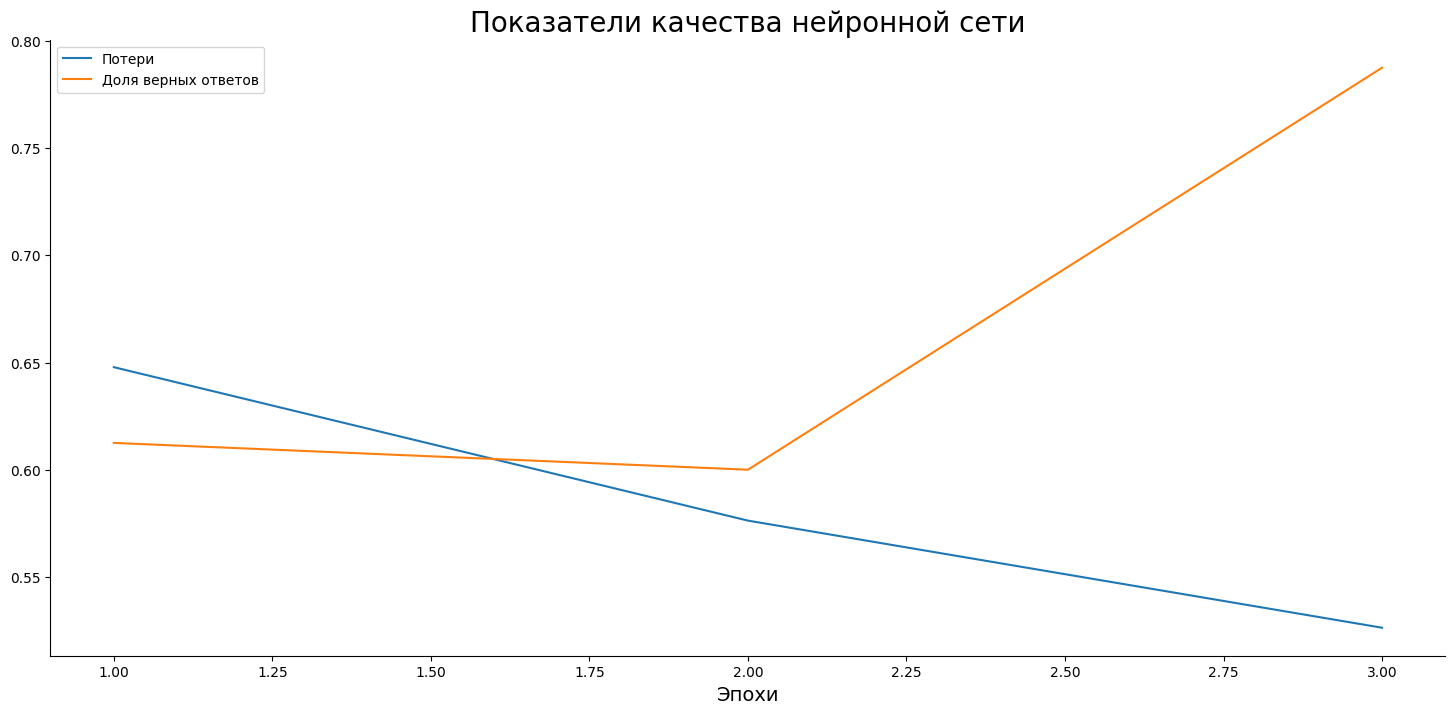

In [40]:
plt.plot(np.arange(1, 4), history.history['loss'], label='Потери')
plt.plot(np.arange(1, 4), history.history['accuracy'], label='Доля верных ответов')
plt.title('Показатели качества нейронной сети', size=20)
plt.xlabel('Эпохи', size=14)
plt.legend();

### Прогнозирование при помощи модели

При помощи обученной нейронной сети получаем на выходе значения, которые можно интерпретировать как вероятности:


In [41]:
prediction = model.predict(X_test)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


array([[0.88290834],
       [0.54723233],
       [0.34173727],
       [0.88068324],
       [0.3261875 ],
       [0.69764   ],
       [0.6173241 ],
       [0.2674524 ],
       [0.6173241 ],
       [0.5393119 ],
       [0.5339648 ],
       [0.9407223 ],
       [0.85933346],
       [0.5952257 ],
       [0.93872195],
       [0.70005155],
       [0.527528  ],
       [0.80577344],
       [0.527528  ],
       [0.24057819]], dtype=float32)

Эти вероятности можно преобразовать в прогнозируемые классы следующим образом (использовано пороговое значение 0.5):

In [42]:
y_pred = np.array([1 if prob > 0.5 else 0 for prob in np.ravel(prediction)])
print(y_pred)

[1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0]


Оценка модели на тестовой выборке выглядит так:

In [43]:
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5500 - loss: 0.5436


(0.5435556173324585, 0.550000011920929)

### Визуализация границы решения

Граница решения для построенного классификатора:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step


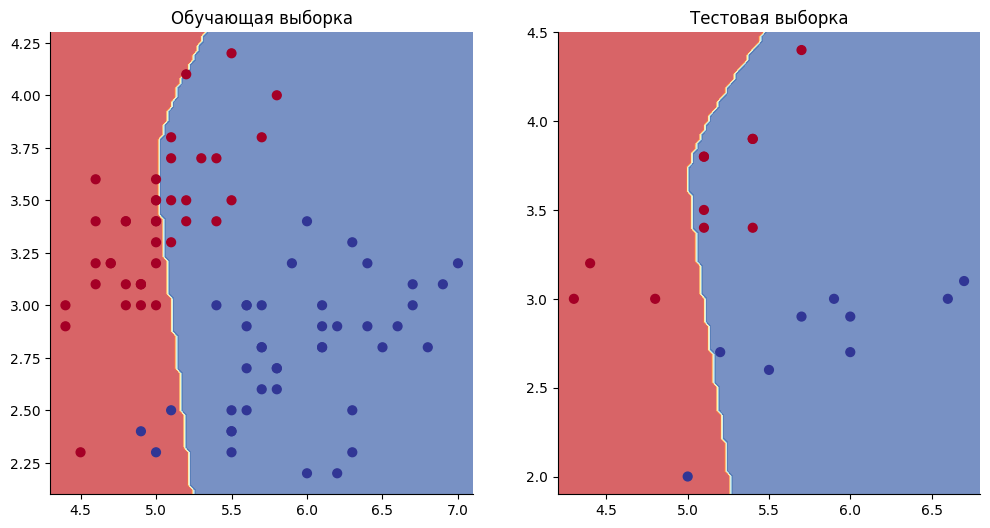

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Обучающая выборка")
plot_decision_boundary(model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Тестовая выборка")
plot_decision_boundary(model, X=X_test, y=y_test)

### Показатели качества бинарной классификации

Когда имеется всего два класса, то будем называть класс $c_{1}$ положительным классом, а класс $c_{2}$ отрицательным классом. Тогда матрица ошибок (confusion matrix) принимает вид:

$$\left(\begin{array}{cc}
TP & FN\\
FP & TN
\end{array}\right),$$

где
* $TP$ – (True Positives) – число корректно спрогнозированных точек в классе $c_{1}$
* $FN$ – (False Negatives) – число точек в классе $c_{1}$, ошибочно спрогнозированных в класс $c_{2}$
* $FP$ – (False Positives) – число точек в классе $c_{2}$, ошибочно спрогнозированных в класс $c_{1}$
* $TN$ – (True Negatives) – число корректно спрогнозированных точек в классе $c_{2}$

Показатели $TN$, $FP$, $FN$ и $TP$ могут быть реализованы так:

In [45]:
def TN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 0))

In [46]:
def FP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 0) & (y_predict == 1))

In [47]:
def FN(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 0))

In [48]:
def TP(y_true, y_predict):
    assert len(y_true) == len(y_predict)
    return np.sum((y_true == 1) & (y_predict == 1))

Матрица ошибок для бинарной классификации определяется так:

In [49]:
def confusion_matrix(y_true, y_predict):
    return np.array([
        [TP(y_true, y_predict), FN(y_true, y_predict)],
        [FP(y_true, y_predict), TN(y_true, y_predict)]
    ])

In [50]:
confusion_matrix(y_test, y_pred)

array([[8, 1],
       [8, 3]])

Наряду с показателями $TP, TN, FP, FN$ могут быть вычислены показатели $TPR=\frac{TP}{TP+FN}$ (доля корректно спрогнозированных положительных точек) и $FPR=\frac{FP}{FP+TN}$ (доля ошибочно  спрогнозированных положительных точек):


In [51]:
def tpr_score(y_true, y_predict):
    tp = TP(y_true, y_predict)
    fn = FN(y_true, y_predict)
    try:
        return tp / (tp + fn)
    except:
        return 0.0

def fpr_score(y_true, y_predict):
    fp = FP(y_true, y_predict)
    tn = TN(y_true, y_predict)
    try:
        return fp / (fp + tn)
    except:
        return 0.0

In [52]:
tpr_score(y_test, y_pred), fpr_score(y_test, y_pred)

(0.8888888888888888, 0.7272727272727273)

### ROC-анализ

ROC-анализ (Receiver Operating Characteristic) – это популярная стратегия оценки производительности бинарных классификаторов. Для ROC-анализа нужен не только прогноз меток класса, но и значения т.н. скоринговой функции для каждой точки в тестовом наборе. В качестве значений скоринговой функции можно взять вероятности, возвращаемые нейронной сетью:

In [53]:
prediction = model.predict(X)
prediction.shape

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


(100, 1)

Пусть $S\left(\mathbf{\overline{x}}_{i}\right)$ – это значение скоринговой функции для точки $\mathbf{\overline{x}}_{i}$ и пусть минимальное и максимальное значения скоринговой функции на наборе данных $\mathbf{D}$ равны $\rho^{min}=\min_{i}S\left(\mathbf{\overline{x}}_{i}\right)$, $\,\rho^{max}=\max_{i}S\left(\mathbf{\overline{x}}_{i}\right)$.

Скоринговая функция применяется для бинарной классификации точек набора данных следующим образом: выбирается некоторый порог отсечения (threshold) и если скоринговая функция принимает на точке значение выше порога отсечения, то точка классифицируется как положительная, иначе, как отрицательная. Далее для каждого значения $\rho\in\left[\rho^{min},\rho^{max}\right]$ определяем множество положительных точек $\mathbf{R_{1}}\left(\rho\right)=\left\{ \mathbf{\overline{x}}_{i}\in\mathbf{D}:S\left(\mathbf{\overline{x}}_{i}\right)>\rho\right\}$  и вычисляем показатели $TPR$ и $FPR$, чтобы получить новую точку на ROC кривой.

Показатель $FPR$ откладывается вдоль оси x, а показатель $TPR$ – вдоль оси y. В результате получаем ROC кривую (кривую Лоренца).


In [54]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

In [55]:
def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):

        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])

    return roc.reshape(-1, 2)

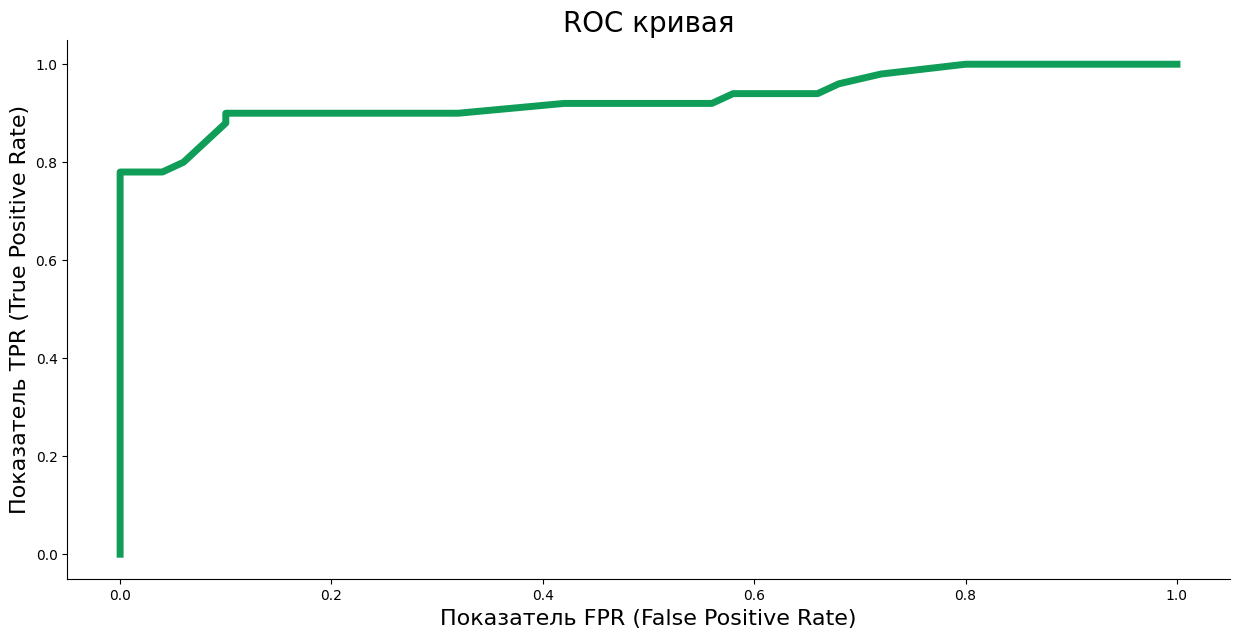

In [56]:
plt.figure(figsize=(15,7))

ROC = roc_from_scratch(prediction.reshape(-1),y,partitions=50)
#plt.scatter(ROC[:,0],ROC[:,1],color='#0F9D58',s=100)
plt.plot(ROC[:,0],ROC[:,1],color='#0F9D58',lw=5)
plt.title('ROC кривая',fontsize=20)
plt.xlabel('Показатель FPR (False Positive Rate)',fontsize=16)
plt.ylabel('Показатель TPR (True Positive Rate)',fontsize=16);

В случае идеального бинарного классификатора верхней левой точкой ROC кривой является точка $\left(0,\,1\right)$, соответствующая значениям $FPR=0$ и $TPR=1$, т.е. у классификатора нет ложно положительных точек и правильно классифицированы все положительные точки (отсюда вытекает, что правильно классифицированы и все отрицательные точки).

Таким образом, ROC-кривая показывает, в какой степени классификатор дает более высокую оценку положительным точкам по сравнению с отрицательными точками. Идеальный классификатор оценивает все положительные точки выше, чем отрицательные. Таким образом, чем ближе ROC кривая к идеальному случаю, тем лучше классификатор.

Площадь под ROC кривой, обозначаемая $AUC$, может быть использована как мера качества классификатора. Так как общая площадь квадрата равна $1$, показатель $AUC$ находится в интервале $\left[0,\,1\right]$ (чем больше, тем лучше).

Для вычисления площади под кривой можно использовать метод трапеций или иной численный метод

### Глубокая нейронная сеть для задачи многоклассовой классификации

Вернемся к исходному набору данных Ирисы:

In [57]:
df = tfds.as_dataframe(ds)
for i in range(4):
    df['V'+str(i)] = df['features'].apply([lambda x:x[i]])
df.drop(columns=['features'],inplace=True)
df.sample(5)

,label,V0,V1,V2,V3
30,1,6.7,3.0,5.0,1.7
133,0,4.4,3.0,1.3,0.2
39,0,5.0,3.4,1.6,0.4
49,2,6.1,2.6,5.6,1.4
63,0,5.0,3.6,1.4,0.2


In [58]:
X = np.array(df.drop('label', axis=1))
y = np.array(df['label'])

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_ratio=0.2, seed=42
)

In [60]:
y_train.shape, y_test.shape

((120,), (30,))

In [61]:
def to_one_hot(labels, dimension=3):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [62]:
list(enumerate(['a','b','c']))

[(0, 'a'), (1, 'b'), (2, 'c')]

In [63]:
y_train = to_one_hot(y_train)
y_test = to_one_hot(y_test)
y_train.shape, y_test.shape

((120, 3), (30, 3))

In [64]:
y_train

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1

In [65]:
feature_normalizer = tf.keras.layers.Normalization(axis=None,input_shape=(X.shape[1],))
feature_normalizer.adapt(X_train)

C:\Users\Mo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
model = tf.keras.Sequential([
    feature_normalizer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(3, activation="softmax")
])

In [67]:
model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [68]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    # уровень выводимой информации
                    verbose=1,
                    # проверка (валидация) на 20% обучающих данных
                    validation_split = 0.2)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3828 - loss: 1.0245 - val_accuracy: 0.8750 - val_loss: 0.9352
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8750 - loss: 0.9280 - val_accuracy: 0.9167 - val_loss: 0.8620
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9583 - loss: 0.8537 - val_accuracy: 0.8333 - val_loss: 0.7965
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9193 - loss: 0.7973 - val_accuracy: 0.9167 - val_loss: 0.7431
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9193 - loss: 0.7360 - val_accuracy: 0.8333 - val_loss: 0.6928
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9271 - loss: 0.6885 - val_accuracy: 0.8333 - val_loss: 0.6482
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9388 - loss: 0.6576 - val_accuracy: 0.8750 - val_loss: 0.6037
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9492 - loss: 0.5978 - val_accuracy: 0.8750 - val_loss: 0.5665
Epoch 9

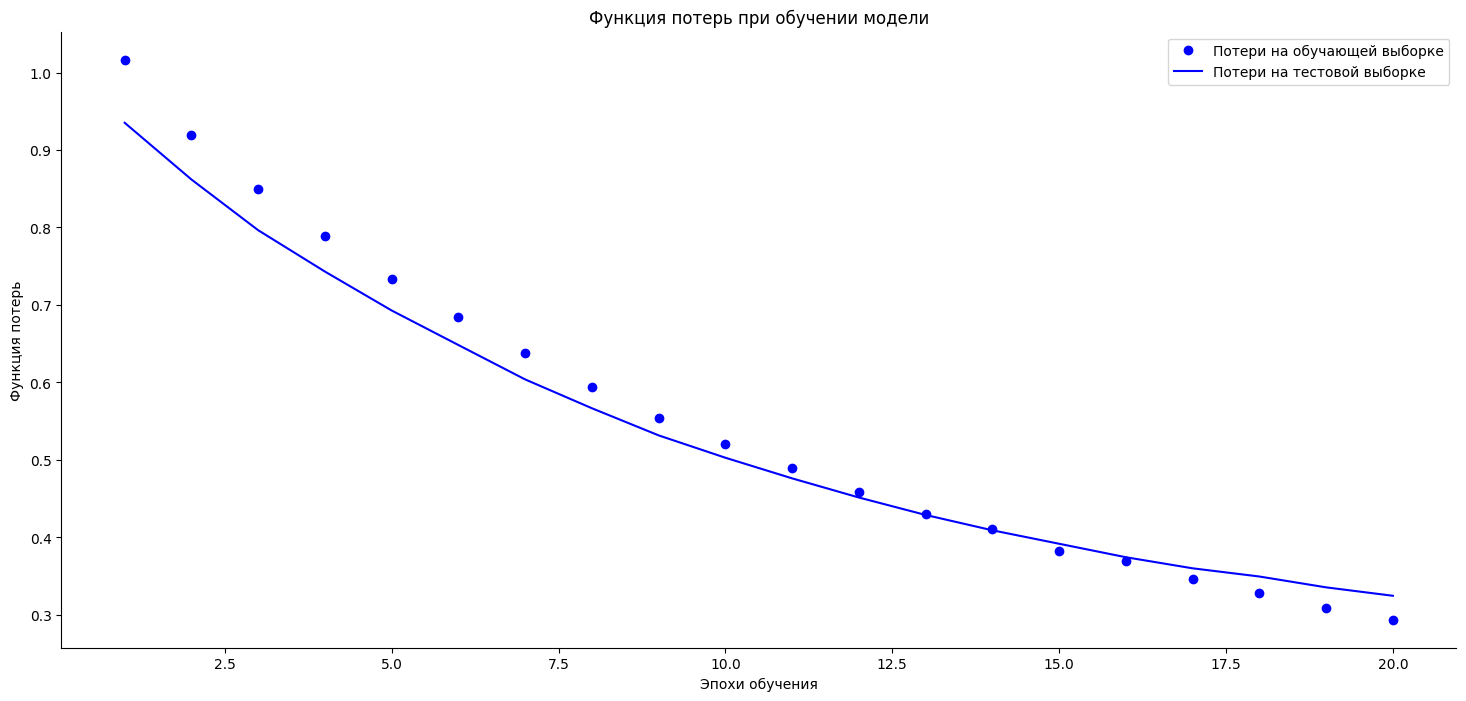

In [69]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Потери на обучающей выборке")
plt.plot(epochs, val_loss, "b", label="Потери на тестовой выборке")
plt.title("Функция потерь при обучении модели")
plt.xlabel("Эпохи обучения")
plt.ylabel("Функция потерь")
plt.legend();

### Создание бинарного набора данных

Загрузим набор данных с информацией о качестве вина на основе физико-химических тестов.

In [70]:
ds = tfds.load("wine_quality", split='train')
df = tfds.as_dataframe(ds)
df.sample(5)

,features/alcohol,features/chlorides,features/citric acid,features/density,features/fixed acidity,features/free sulfur dioxide,features/pH,features/residual sugar,features/sulphates,features/total sulfur dioxide,features/volatile acidity,quality
2588,11.9,0.039,0.40,0.99360,8.2,35.0,3.15,6.3,0.34,162.0,0.35,7
3199,12.2,0.031,0.31,0.99235,7.0,38.0,3.38,6.4,0.58,115.0,0.32,7
2986,9.2,0.056,0.64,0.99720,7.1,12.0,3.05,13.2,0.39,105.0,0.33,5
4515,13.7,0.024,0.32,0.98906,5.8,28.0,3.25,4.5,0.52,94.0,0.31,7
1666,11.4,0.051,0.28,0.99570,8.0,25.0,3.06,10.8,0.47,157.0,0.45,7


Оставим в наборе данных два независимых признака `features/density` и `features/alcohol` и метки классов `quality`,  убрав из названий признаков строку `features/`:

In [71]:
df = df[['features/density','features/alcohol','quality']]
df.columns = ['density','alcohol','quality']
df.head()

,density,alcohol,quality
0,1.00080,9.0,5
1,0.99110,12.2,6
2,0.99076,11.2,4
3,0.99672,9.0,6
4,0.99016,12.0,6


Оценим количество записей с различными значениями признака `quality`:

In [72]:
df['quality'].unique()

array([5, 6, 4, 8, 7, 3, 9])

In [73]:
df['quality'].value_counts().sort_index()

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64

Объявим винами высшего качества вина с индексом качестве более или равным 6:

In [74]:
df['top'] = [1 if quality >= 6 else 0 for quality in df['quality']]
df.drop('quality', axis=1, inplace=True)

df.head()

C:\Users\Mo\AppData\Local\Temp\ipykernel_144\1968197607.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['top'] = [1 if quality >= 6 else 0 for quality in df['quality']]
C:\Users\Mo\AppData\Local\Temp\ipykernel_144\1968197607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('quality', axis=1, inplace=True)


,density,alcohol,top
0,1.00080,9.0,0
1,0.99110,12.2,1
2,0.99076,11.2,0
3,0.99672,9.0,1
4,0.99016,12.0,1


### Если нейронная сеть не обучается...

* Проверьте отсутствие ошибок в коде – могут быть ошибки, которые не создают исключений, но не дают нейронной сети обучиться
* Проверьте, что нейронная сеть формирует выход на каких-нибудь тестовых данных. Убедитесь, что на других тестовых данных выход будет отличаться.
* Проверьте, что входные данные нормализованы (стандартизованы или масштабированы на отрезок $[0, 1]$ или $[-1, 1]$)
* Поработайте с набором данных – уберите выбросы, попробуйте обучить сеть не на всем наборе, а на случайной выборке
* Измените параметры обучения – поменяйте оптимизатор, начальный шаг обучения и т.п.
* Измените способ начальной инициализации весов в скрытых слоях, например:
`kernel_initializer='he_normal'`
* Измените параметры (в т.ч. по умолчанию) в методе `fit()`, например, количество эпох, размер пакета `batch_size` и пр.


#### Задание (10 баллов)

Для закрепленного за Вами варианта работы:

1. Загрузите заданный в индивидуальном задании набор данных из Tensorflow Datasets, включая указанные в задании независимые признаки и метку класса. Оставьте в наборе признаки, принимающие числовые значения.
2. Визуализируйте точки набора данных на плоскости с координатами, соответствующими двум независимым признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.
3. Если признак с метками классов содержит более двух классов, то объедините некоторые классы, чтобы получить набор для бинарной классификации. Объединяйте классы таким образом, чтобы положительный и отрицательный классы были сопоставимы по количеству точек.
4. Разбейте набор данных из двух признаков и бинарных меток класса на обучающую и тестовую выборки. Постройте нейронные сети с нормализующим слоем и параметрами, указанными в индивидуальном задании, для бинарной классификации и обучите их на обучающей выборке, контролируя процесс обучения нейронных сетей. Определите нейронную сеть с более высоким качеством бинарной классификации по показателю бинарной классификации, указанному в индивидуальном задании.
5. Визуализируйте границы принятия решений построенных нейронных сетей на отдельных рисунках на всем наборе данных из двух признаков и бинарных меток классов.
6. Визуализируйте на одном рисунке ROC-кривые для построенных классификаторов на основе нейронных сетей, вычислите площади под ROC-кривыми методом трапеций или иным методом и создайте легенду с указанием площадей кривых.
7. Определите исходном наборе данных дополнительный признак, отличный от указанных в задании двух независимых признаков, принимающий непрерывные значения и имеющий максимальную дисперсию.
8. Визуализируйте точки набора данных в трехмерном пространстве с координатами, соответствующими трем независимым признакам, отображая точки различных классов разными цветами. Подпишите оси и рисунок, создайте легенду для классов набора данных.
9. Разбейте исходный набор данных на обучающую и тестовую выборки. Постройте нейронную сеть для многоклассовой классификации с нормализующим слоем и параметрами, соответствующими лучшей нейронной сети для бинарной классифиации из п.4, и обучите ее на обучающей выборке, контролируя процесс ее обучения.
10. Постройте кривые обучения в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.


